In [1]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt

# The approach

<h5>Let’s start with a few definitions, rephrased in the context of the TSP:</h5>
<li>
Gene: a city (represented as (x, y) coordinates)
</li><li>
Individual (aka “chromosome”): a single route satisfying the conditions above
</li><li>   
Population: a collection of possible routes (i.e., collection of individuals)
    </li><li>
Parents: two routes that are combined to create a new route
    </li><li>
Mating pool: a collection of parents that are used to create our next population (thus creating the next generation of routes)</li><li>
Fitness: a function that tells us how good each route is (in our case, how short the distance is)</li><li>
Mutation: a way to introduce variation in our population by randomly swapping two cities in a route</li><li>
Elitism: a way to carry the best individuals into the next generation</li>


<h4>Our GA will proceed in the following steps:</h4>

1. Create the population

2. Determine fitness

3. Select the mating pool

4. Breed

5. Mutate

6. Repeat

## Create necessary classes and functions

### Create City class

<br>
We first create a City class that will allow us to create and handle our cities. These are simply our (x, y) coordinates. Within the City class, we add a distance calculation (making use of the Pythagorean theorem) in line 6 and a cleaner way to output the cities as coordinates with __repr__ in line 12. </p>

In [2]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

## Create a fitness class
<br>
We’ll also create a Fitness class. In our case, we’ll treat the fitness as the inverse of the route distance. We want to minimize route distance, so a larger fitness score is better. Based on Rule #2, we need to start and end at the same place, so this extra calculation is accounted for in line 13 of the distance calculation.

In [3]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

## Create our initial population

### Route generator

We now can make our initial population (aka first generation). To do so, we need a way to create a function that produces routes that satisfy our conditions (Note: we’ll create our list of cities when we actually run the GA at the end of the tutorial). To create an individual, we randomly select the order in which we visit each city:

In [4]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

### Create first "population" (list of routes)
This produces one individual, but we want a full population, so let’s do that in our next function. This is as simple as looping through the createRoute function until we have as many routes as we want for our population.

In [5]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

Note: we only have to use these functions to create the initial population. Subsequent generations will be produced through breeding and mutation.

## Create the genetic algorithm

### Rank individuals
Next, the evolutionary fun begins. To simulate our “survival of the fittest”, we can make use of Fitness to rank each individual in the population. Our output will be an ordered list with the route IDs and each associated fitness score.

In [6]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

### Roulette Wheel Selection Scheme
There are a few options for how to select the parents that will be used to create the next generation. The most common approache is fitness proportionate selection (aka “roulette wheel selection”).
<br>
<br>
For the purpose of clarity, we’ll create the mating pool in two steps. First, we’ll use the output from rankRoutes to determine which routes to select in our selection function. In lines 3–5, we set up the roulette wheel by calculating a relative fitness weight for each individual. In line 9, we compare a randomly drawn number to these weights to select our mating pool. We’ll also want to hold on to our best routes, so we introduce elitism in line 7. Ultimately, the selection function returns a list of route IDs, which we can use to create the mating pool in the matingPool function.
<br>
<br>
<br>
Create a selection function that will be used to make the list of parent routes

In [7]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

Now that we have the IDs of the routes that will make up our mating pool from the selection function, we can create the mating pool. We’re simply extracting the selected individuals from our population.
#### Create mating pool

In [8]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

However, the TSP is unique in that we need to include all locations exactly one time. To abide by this rule, we can use a special breeding function called ordered crossover. In ordered crossover, we randomly select a subset of the first parent string (see line 12 in breed function below) and then fill the remainder of the route with the genes from the second parent in the order in which they appear, without duplicating any genes in the selected subset from the first parent (see line 15 in breed function below).
<br>
<br>
<br>
Create a crossover function for two parents to create one child

<img src = https://miro.medium.com/v2/resize:fit:1400/format:webp/1*YhmzBBCyAG3rtEBbI0gz4w.jpeg></img>

In [9]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

### Create function to run crossover over full mating pool
Next, we’ll generalize this to create our offspring population. In line 5, we use elitism to retain the best routes from the current population. Then, in line 8, we use the breed function to fill out the rest of the next generation.

In [10]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

### Create function to mutate a single route
since we need to abide by our rules, we can’t drop cities. Instead, we’ll use swap mutation. This means that, with specified low probability, two cities will swap places in our route. We’ll do this for one individual in our mutate function:

In [11]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

Create function to run mutation over entire population

In [12]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

### Put all steps together to create the next generation
We’re almost there. Let’s pull these pieces together to create a function that produces a new generation. First, we rank the routes in the current generation using rankRoutes. We then determine our potential parents by running the selection function, which allows us to create the mating pool using the matingPool function. Finally, we then create our new generation using the breedPopulation function and then applying mutation using the mutatePopulation function.

In [13]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

## Final step: create the genetic algorithm
We finally have all the pieces in place to create our GA! All we need to do is create the initial population, and then we can loop through as many generations as we desire. Of course we also want to see the best route and how much we’ve improved, so we capture the initial distance in line 3 (remember, distance is the inverse of the fitness), the final distance in line 8, and the best route in line 9.

In [14]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

## Running the genetic algorithm

## Create list of cities
With everything in place, solving the TSP is as easy as two steps:

First, we need a list of cities to travel between. For this demonstration, we’ll create a list of 25 random cities (a seemingly small number of cities, but brute force would have to test over 300 sextillion routes!):

In [25]:
cityList = []

for i in range(0,25):
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))
cityList

[(76,80),
 (55,35),
 (145,52),
 (186,17),
 (165,116),
 (95,192),
 (187,90),
 (134,159),
 (153,8),
 (110,45),
 (121,42),
 (189,28),
 (179,140),
 (32,159),
 (17,191),
 (59,195),
 (120,157),
 (115,196),
 (113,123),
 (75,133),
 (104,58),
 (2,129),
 (99,193),
 (130,136),
 (190,83)]

In [26]:
# get cities info
cities = []
def getCity():

    f = open("TSP51.txt")
    for i in f.readlines():
        node_city_val = i.split()
        cities.append(
            [node_city_val[0], float(node_city_val[1]), float(node_city_val[2])]
        )

    return cities
getCity()

[['1', 37.0, 52.0],
 ['2', 49.0, 49.0],
 ['3', 52.0, 64.0],
 ['4', 20.0, 26.0],
 ['5', 40.0, 30.0],
 ['6', 21.0, 47.0],
 ['7', 17.0, 63.0],
 ['8', 31.0, 62.0],
 ['9', 52.0, 33.0],
 ['10', 51.0, 21.0],
 ['11', 42.0, 41.0],
 ['12', 31.0, 32.0],
 ['13', 5.0, 25.0],
 ['14', 12.0, 42.0],
 ['15', 36.0, 16.0],
 ['16', 52.0, 41.0],
 ['17', 27.0, 23.0],
 ['18', 17.0, 33.0],
 ['19', 13.0, 13.0],
 ['20', 57.0, 58.0],
 ['21', 62.0, 42.0],
 ['22', 42.0, 57.0],
 ['23', 16.0, 57.0],
 ['24', 8.0, 52.0],
 ['25', 7.0, 38.0],
 ['26', 27.0, 68.0],
 ['27', 30.0, 48.0],
 ['28', 43.0, 67.0],
 ['29', 58.0, 48.0],
 ['30', 58.0, 27.0],
 ['31', 37.0, 69.0],
 ['32', 38.0, 46.0],
 ['33', 46.0, 10.0],
 ['34', 61.0, 33.0],
 ['35', 62.0, 63.0],
 ['36', 63.0, 69.0],
 ['37', 32.0, 22.0],
 ['38', 45.0, 35.0],
 ['39', 59.0, 15.0],
 ['40', 5.0, 6.0],
 ['41', 10.0, 17.0],
 ['42', 21.0, 10.0],
 ['43', 5.0, 64.0],
 ['44', 30.0, 15.0],
 ['45', 39.0, 10.0],
 ['46', 32.0, 39.0],
 ['47', 25.0, 32.0],
 ['48', 25.0, 55.0],
 ['49',

### Run the genetic algorithm
Then, running the genetic algorithm is one simple line of code. This is where art meets science; you should see which assumptions work best for you. In this example, we have 100 individuals in each generation, keep 20 elite individuals, use a 1% mutation rate for a given gene, and run through 500 generations:

In [24]:
geneticAlgorithm(population=cities, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)

ZeroDivisionError: float division by zero

## Plot the progress

Note, this will win run a separate GA

In [17]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

Run the function with our assumptions to see how distance has improved in each generation

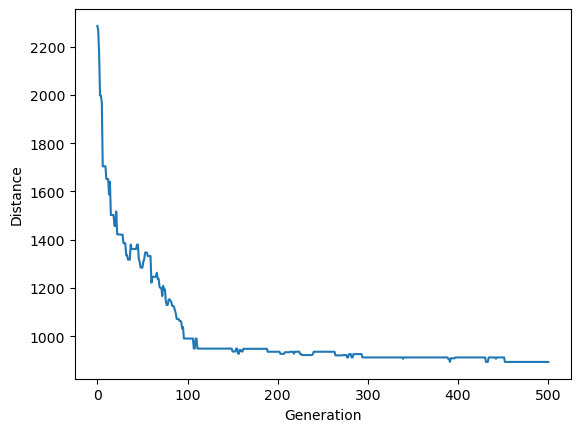

In [18]:
geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)